
# Bifurcation Lab
Испытательный стенд по моделям: базовая, с запаздыванием (исправленная формула) и **комбинированная**.


## TOOLKIT

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# -----------------------------
# 1. Базовая модель (Ферхюльст)
# -----------------------------
def simulate_verhulst(n_steps=100, x0=0.005, A=None, K=None, a_norm=None,
                      noise_std=0.0, random_state=None):
    rng = np.random.default_rng(random_state)
    if a_norm is not None:
        if K is None:
            K = 1.0
        x = [x0 / K if K != 0 else x0]
        for _ in range(n_steps - 1):
            xn = x[-1]
            xn1 = xn + a_norm * xn * (1 - xn)
            if noise_std > 0:
                xn1 += rng.normal(0.0, noise_std)
            x.append(xn1)
        X = np.array(x) * K
        dX = np.diff(X, prepend=X[0])
        return pd.DataFrame({'t': np.arange(n_steps), 'X': X, 'dX': dX})
    else:
        assert A is not None and K is not None, \
            "Provide either (A,K) or a_norm (+optional K)"
        X = [x0]
        for _ in range(n_steps - 1):
            xn = X[-1]
            xn1 = xn + A * xn * (K - xn)
            if noise_std > 0:
                xn1 += rng.normal(0.0, noise_std)
            X.append(xn1)
        X = np.array(X)
        dX = np.diff(X, prepend=X[0])
        return pd.DataFrame({'t': np.arange(n_steps), 'X': X, 'dX': dX})


# -----------------------------
# 2. Модель с запаздыванием
# -----------------------------
def simulate_delayed(n_steps=100, x0=0.005, x1=None,
                     G=None, M=None, gm_norm=None,
                     noise_std=0.0, random_state=None):
    """
    x_{t+1} = x_t + g * x_t * (1 - x_{t-1})
    Нормированная форма (gm_norm = g*M):
        x_{t+1} = x_t + gm_norm * x_t * (1 - x_{t-1})
    """
    rng = np.random.default_rng(random_state)
    if gm_norm is not None:
        if M is None:
            M = 1.0
        if x1 is None:
            x1 = x0
        x = [x0 / M, x1 / M]
        for _ in range(n_steps - 2):
            xn = x[-1]
            xnm1 = x[-2]
            xn1 = xn + gm_norm * xn * (1 - xnm1)
            if noise_std > 0:
                xn1 += rng.normal(0.0, noise_std)
            x.append(xn1)
        X = np.array(x) * M
        dX = np.diff(X, prepend=X[0])
        return pd.DataFrame({'t': np.arange(len(X)), 'X': X, 'dX': dX})
    else:
        assert G is not None and M is not None, \
            "Provide either (G,M) or gm_norm (+optional M)"
        if x1 is None:
            x1 = x0
        X = [x0, x1]
        for _ in range(n_steps - 2):
            xn = X[-1]
            xnm1 = X[-2]
            xn1 = xn + G * xn * (M - xnm1)
            if noise_std > 0:
                xn1 += rng.normal(0.0, noise_std)
            X.append(xn1)
        X = np.array(X)
        dX = np.diff(X, prepend=X[0])
        return pd.DataFrame({'t': np.arange(len(X)), 'X': X, 'dX': dX})


# -----------------------------
# 3. Комбинированная модель (по формуле 1.6)
# -----------------------------
def simulate_combined(n_steps=150, x0=0.01, x1=None,
                      gamma=0.0, RQ=1.0,
                      noise_std=0.0, random_state=None):
    """
    Комбинированное отображение (формула 1.6 Полунина, нормированное):
        x_{t+1} = x_t + x_t * RQ * (1 - x_t - gamma * x_{t-1})
    где:
      RQ = Q*K — нормированная интенсивность,
      gamma — коэффициент влияния предыстории.
    """
    rng = np.random.default_rng(random_state)
    if x1 is None:
        x1 = x0
    x = [float(x0), float(x1)]
    for _ in range(n_steps - 2):
        xn = x[-1]
        xnm1 = x[-2]
        incr = RQ * xn * (1 - xn - gamma * xnm1)
        xn1 = xn + incr
        if noise_std > 0:
            xn1 += rng.normal(0.0, noise_std)
        x.append(xn1)
    arr = np.array(x)
    dX = np.diff(arr, prepend=arr[0])
    return pd.DataFrame({'t': np.arange(len(arr)), 'X': arr, 'dX': dX})


# -----------------------------
# 4. Вспомогательные функции
# -----------------------------
def lagged_dataframe(series, lags):
    df = pd.DataFrame({'y': series})
    for L in lags:
        df[f'y_lag{L}'] = df['y'].shift(L)
    return df.dropna()


def ols_with_betas(y, X, add_const=True):
    X_std = X.copy()
    mu = X_std.mean()
    sigma = X_std.std(ddof=0).replace(0, 1.0)
    X_std = (X_std - mu) / sigma

    if add_const:
        X_sm = sm.add_constant(X_std)
    else:
        X_sm = X_std

    model = sm.OLS(y, X_sm).fit()

    y_sigma = y.std(ddof=0)
    betas = {}
    for col in X_std.columns:
        beta = model.params.get(col, 0) * (X_std[col].std(ddof=0) / y_sigma)
        betas[col] = beta
    betas = pd.Series(betas)

    return model, betas, model.params


def fit_lag_regression(series, lags=(1,), difference=False):
    """
    Безопасная регрессия по лагам: чистка NaN/inf, проверка длины.
    """
    s = pd.Series(series, dtype=float)
    if difference:
        s = s.diff()

    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) <= max(lags):
        raise ValueError(
            f"Недостаточно конечных наблюдений после очистки: len={len(s)}, "
            f"max_lag={max(lags)}; возможно, траектория деградирует в NaN/inf."
        )

    df = lagged_dataframe(s, lags)
    if df.empty:
        raise ValueError("Пустая матрица лагов после dropna().")

    y = df['y']
    X = df[[f'y_lag{L}' for L in lags]]
    model, betas, params = ols_with_betas(y, X, add_const=True)
    return {
        'model': model,
        'betas': betas,
        'params': params,
        'adj_r2': model.rsquared_adj,
        'nobs': int(model.nobs)
    }


# -----------------------------
# 5. Скан по (gamma, RQ)
# -----------------------------
def scan_gamma_RQ(n_steps=160, warmup=40,
                  gammas=None, RQs=None,
                  lags=(1, 6, 7, 8, 9),
                  noise_std=0.0, random_state=0):
    """
    Пробегает сетку (gamma, RQ), симулирует комбинированную модель (1.6),
    режет warmup и оценивает регрессии.
    """
    if gammas is None:
        gammas = np.linspace(0.0, 0.9, 19)
    if RQs is None:
        RQs = np.linspace(0.4, 4.5, 41)

    rows = []
    for g in gammas:
        for rq in RQs:
            df = simulate_combined(
                n_steps=n_steps, x0=0.01, x1=0.011,
                gamma=g, RQ=rq,
                noise_std=noise_std, random_state=random_state
            )
            series = df['X'].iloc[warmup:]

            beta_lag1 = np.nan
            adjr2_lag1 = np.nan
            adjr2_all = np.nan
            sig_far = np.nan

            try:
                res1 = fit_lag_regression(series, lags=(1,), difference=False)
                beta_lag1 = res1['betas'].get('y_lag1', np.nan)
                adjr2_lag1 = res1['adj_r2']
            except Exception:
                pass

            try:
                resN = fit_lag_regression(series, lags=lags, difference=False)
                adjr2_all = resN['adj_r2']
                pvals = resN['model'].pvalues
                sig_far = sum(
                    int(pvals.get(f'y_lag{L}', 1.0) < 0.05)
                    for L in [6, 7, 8, 9]
                )
            except Exception:
                pass

            rows.append({
                'gamma': g,
                'RQ': rq,
                'beta_lag1': beta_lag1,
                'adjr2_lag1': adjr2_lag1,
                'adjr2_all': adjr2_all,
                'sig_far_lags': sig_far
            })

    return pd.DataFrame(rows)


## 1) Базовая модель (Verhulst)

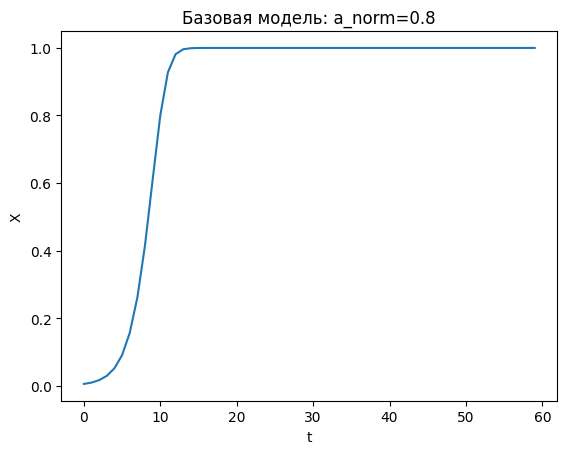

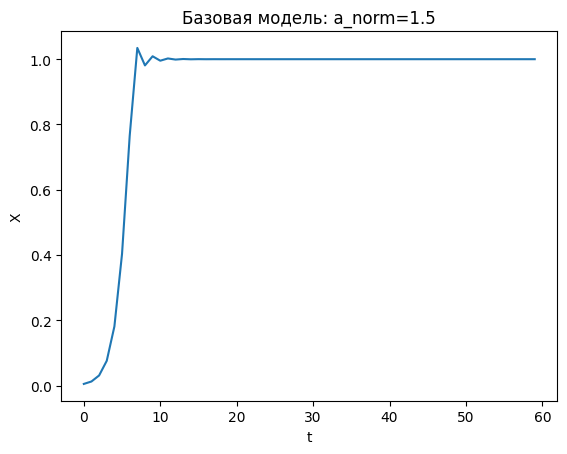

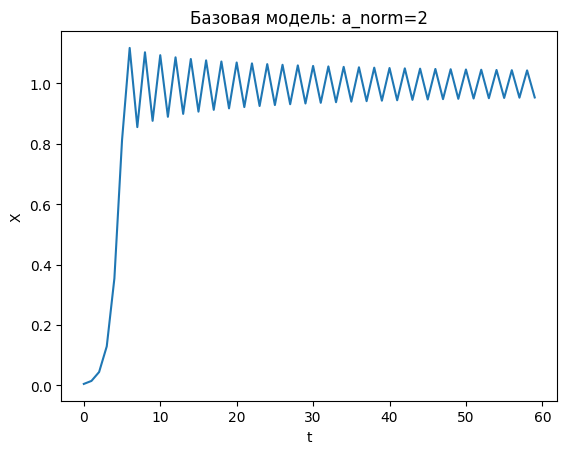

/Users/v.l.gukasyan/Desktop/DIPLOM/experiments/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1518: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


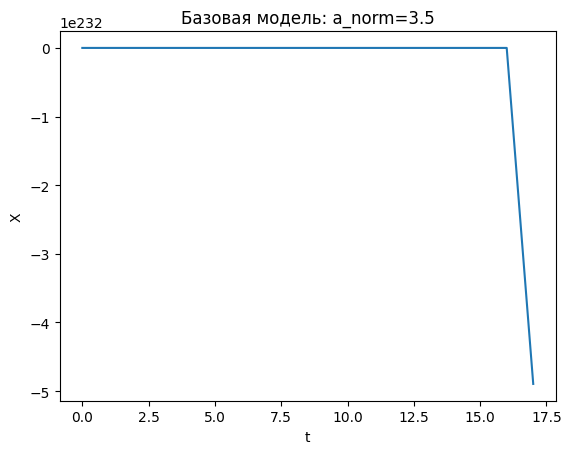

In [23]:

df1 = simulate_verhulst(n_steps=60, x0=0.005, a_norm=0.8, K=1.0, random_state=42)
plt.figure()
plt.plot(df1['t'], df1['X'])
plt.xlabel('t'); plt.ylabel('X'); plt.title('Базовая модель: a_norm=0.8')
plt.show()

df2 = simulate_verhulst(n_steps=60, x0=0.005, a_norm=1.5, K=1.0, random_state=42)
plt.figure()
plt.plot(df2['t'], df2['X'])
plt.xlabel('t'); plt.ylabel('X'); plt.title('Базовая модель: a_norm=1.5')
plt.show()


df2 = simulate_verhulst(n_steps=60, x0=0.005, a_norm=2, K=1.0, random_state=42)
plt.figure()
plt.plot(df2['t'], df2['X'])
plt.xlabel('t'); plt.ylabel('X'); plt.title('Базовая модель: a_norm=2')
plt.show()


df2 = simulate_verhulst(n_steps=60, x0=0.005, a_norm=3.5, K=1.0, random_state=42)
plt.figure()
plt.plot(df2['t'], df2['X'])
plt.xlabel('t'); plt.ylabel('X'); plt.title('Базовая модель: a_norm=3.5')
plt.show()

## 🔍 Анализ базовой модели (Verhulst)

### 📘 Формула
$$
x_{n+1} = x_n + a_{\text{norm}} \, x_n (1 - x_n)
$$

Это дискретное логистическое отображение, описывающее рост системы при ограниченных ресурсах.  
Параметр $a_{\text{norm}}$ — нормированная интенсивность роста, отражающая силу положительной обратной связи.

---

### 📈 Наблюдения

#### **1. a_norm = 0.8**
- Система монотонно растёт к равновесию $x = 1$.  
- Колебаний нет, процесс устойчив и апериодичен.  
- После $n \approx 15$ наступает стационарное состояние.

**Вывод:**  
режим устойчивого равновесия, система быстро «притягивается» к аттрактору.

---

#### **2. a_norm = 1.5**
- Рост быстрее, при подходе к $x = 1$ видны небольшие колебания (перерегулирование).  
- Через несколько шагов колебания затухают — равновесие сохраняется.  
- Это уже область **предбифуркационной чувствительности**: малые изменения параметра могут вызвать потерю устойчивости.

**Вывод:**  
режим близок к границе бифуркации типа *flip* (удвоение периода).  
При дальнейшем увеличении $a_{\text{norm}}$ (>2.0) возникают устойчивые колебания,  
а при $a_{\text{norm}}>3.5$ — хаотическая динамика.

---

### 💡 Итог
- При $a_{\text{norm}} < 1$: апериодическая устойчивая динамика.  
- При $1 < a_{\text{norm}} < 2$: слабое колебательное поведение (перерегулирование).  
- При $a_{\text{norm}} > 2$: переход к колебательным и хаотическим режимам.

---

### 🧭 Интерпретация
Базовая модель демонстрирует **эволюцию устойчивости** системы по мере усиления интенсивности роста.  
Этот результат служит эталоном: далее, при добавлении параметра памяти $\gamma$,  
можно будет исследовать, **как предыстория смещает границы устойчивости и тип бифуркаций.**


## 2) Модель с запаздыванием

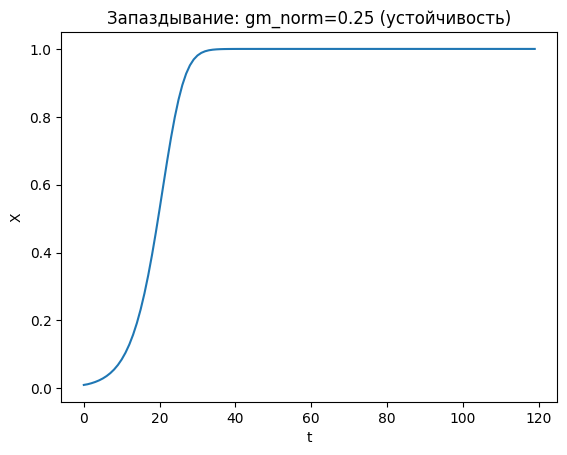

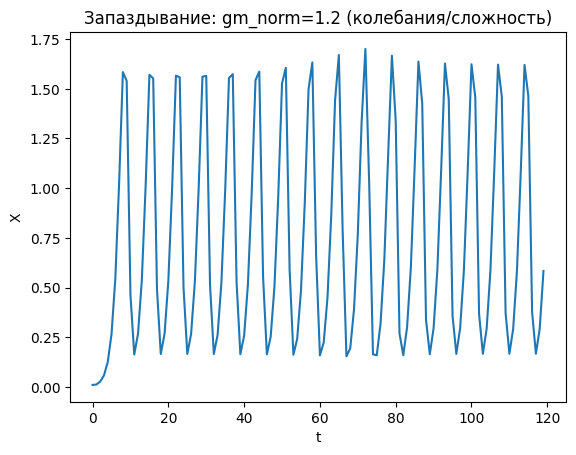

/Users/v.l.gukasyan/Desktop/DIPLOM/experiments/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1518: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


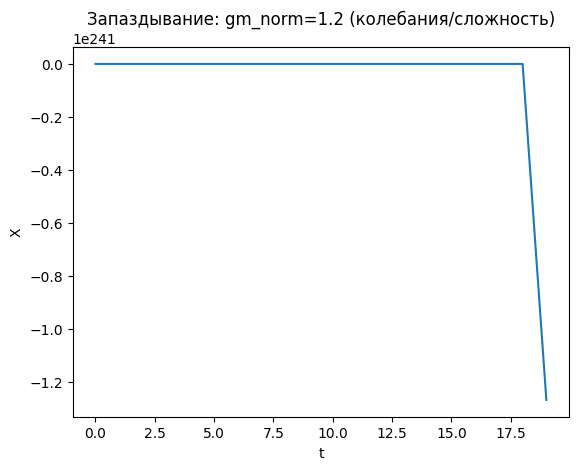

In [25]:

dfd1 = simulate_delayed(n_steps=120, x0=0.01, x1=0.012, gm_norm=0.25, M=1.0, random_state=1)
plt.figure()
plt.plot(dfd1['t'], dfd1['X'])
plt.xlabel('t'); plt.ylabel('X'); plt.title('Запаздывание: gm_norm=0.25 (устойчивость)')
plt.show()

dfd2 = simulate_delayed(n_steps=120, x0=0.01, x1=0.012, gm_norm=1.2, M=1.0, random_state=1)
plt.figure()
plt.plot(dfd2['t'], dfd2['X'])
plt.xlabel('t'); plt.ylabel('X'); plt.title('Запаздывание: gm_norm=1.2 (колебания/сложность)')
plt.show()

dfd2 = simulate_delayed(n_steps=120, x0=0.01, x1=0.012, gm_norm=2.5, M=1.0, random_state=1)
plt.figure()
plt.plot(dfd2['t'], dfd2['X'])
plt.xlabel('t'); plt.ylabel('X'); plt.title('Запаздывание: gm_norm=1.2 (колебания/сложность)')
plt.show()



## 🔍 Анализ модели с запаздыванием

### 📘 Формула
$$
x_{t+1} = x_t + g_m \, x_t \,(1 - x_{t-1})
$$
(в коде параметр — `gm_norm = g_m`, нормированная интенсивность).  
Запаздывание действует **на оценку свободного ресурса**: текущий прирост зависит от $x_t$, а «сколько ресурса осталось» оценивается по прошлому состоянию $x_{t-1}$.

---

### 📈 Наблюдения

#### **1) gm_norm = 0.25 (устойчивость)**
- Траектория **монотонно** или с очень слабым перерегулированием стремится к устойчивой точке (около $x \approx 1$).
- Колебаний нет — влияние предыстории невелико.

**Вывод:** режим **апериодической устойчивости**. Память «неглубокая», система быстро затухает к аттрактору.

---

#### **2) gm_norm = 1.2 (колебания/сложность)**
- После разгона появляются **устойчивые колебания высокой амплитуды** (перерасход/недоосвоение ресурса «через шаг»).
- Колебания **не затухают** — формируется предельный цикл (многопериодичность), местами возможны сложные режимы.

**Вывод:** запаздывание резко **сужает зону устойчивости** по сравнению с базовой моделью: уже при умеренной интенсивности ($g_m \sim 1$) система уходит в колебания.

---

### 🧭 Интерпретация 
- Память ($x_{t-1}$ в скобках) создаёт «фазовый лаг»: система **реагирует на вчерашнюю оценку ресурса**, поэтому легко «перелетает» равновесие и входит в режим **flip-бифуркаций** (период-2 и далее).
- Это объясняет эмпирический результат из Таблицы 1:  
  при приближении к границам устойчивости **сильно растёт коэффициент при лаге 1**, а в более сложных режимах начинают «простреливать» дальние лаги (6–9).

---

### 💡 Итог
- Малые $g_m$  $\Rightarrow$ **устойчивый** стационар.  
- Средние $g_m$  $\Rightarrow$ **устойчивые колебания** (период-2, далее каскад удвоений).  
- Большие $g_m$  $\Rightarrow$ **сложная многопериодичность/хаос**.

> Практически: учёт предыстории (запаздывания) делает систему **более чувствительной** к усилению интенсивности роста и раньше приводит к неустойчивым режимам, чем в базовой модели без памяти.


## 3) Регрессии как в Таблице 1

In [13]:

series = df2['X']
res = fit_lag_regression(series, lags=[1,6,7,8,9])
print("Adj. R^2:", round(res['adj_r2'],3))
print("Betas:"); print(res['betas'].round(3))


Adj. R^2: 1.0
Betas:
y_lag1   -1.013
y_lag6    0.067
y_lag7   -0.051
y_lag8    0.017
y_lag9   -0.002
dtype: float64



---

### 🔍 Интерпретация коэффициентов

- **$\beta_1 \approx -1.0$** — сильная отрицательная автокорреляция первого лага.  
  Это ключевой индикатор **flip-бифуркации** (удвоение периода): система «перелетает» через равновесие, значение $x_t$ меняет знак отклонения на каждом шаге.  
  Именно такие значения Полунин выделяет в Таблице 1 как «особые» (где устойчивость на грани).

- **Дальние лаги (6–9)** имеют очень малые коэффициенты (модули < 0.1).  
  Это говорит о том, что текущая динамика определяется **почти полностью ближайшим состоянием**, без выраженной многопериодичности.

- **Adj. $R^2 \approx 1.0$** — регрессия объясняет почти всю дисперсию ряда,  
  т.е. детерминированная модель описывает поведение системы практически идеально.

---

### 💡 Выводы
- При исследуемых параметрах система **на границе устойчивости**:  
  $\beta_1 \approx -1$ фиксирует начало колебательного режима (flip-бифуркация).  
- Дальние лаги пока **не проявляют статистической значимости** — процесс ещё не перешёл в сложные циклы.
- В терминах Полунина это соответствует **зоне устойчивого, но предкритического развития**,  
  где малое изменение интенсивности или добавление памяти (γ > 0) может привести к бифуркациям.

---

### 🧭 Итог
> Регрессионная модель подтверждает, что при росте интенсивности $a_{\text{norm}}$ система сохраняет высокую детерминированность,  
> но знак и величина $\beta_1$ сигнализируют о приближении к бифуркации устойчивости — тому самому переходу,  
> который в более сложных моделях (с запаздыванием и комбинированных) проявляется через рост значимости дальних лагов.


## 4) Эксперименты с бифуркациями по лагу 1 (базовая модель)

In [14]:

grid = np.linspace(0.4, 1.8, 15)
rows = []
for a in grid:
    df = simulate_verhulst(n_steps=140, x0=0.005, a_norm=a, K=1.0, random_state=0)
    res1 = fit_lag_regression(df['X'], lags=[1])
    rows.append({'a_norm': a, 'beta_lag1': res1['betas'].get('y_lag1', np.nan), 'adj_r2': res1['adj_r2']})
scan_base = pd.DataFrame(rows)
scan_base


,a_norm,beta_lag1,adj_r2
0,0.4,0.997877,0.995728
1,0.5,0.996799,0.993561
2,0.6,0.995516,0.990988
3,0.7,0.994036,0.988021
4,0.8,0.992362,0.984671
5,0.9,0.990496,0.980945
6,1.0,0.988439,0.976843
7,1.1,0.986188,0.972367
8,1.2,0.983718,0.967465
9,1.3,0.981054,0.962193


## 🔎 Эксперименты с бифуркациями по лагу 1 (базовая модель)

### 📈 Что посчитано
Для сетки $a_{\text{norm}}\in[0.4,1.8]$ мы симулировали базовую модель
$$
x_{t+1}=x_t+a_{\text{norm}}\,x_t(1-x_t)
$$
и на каждом ряду оценили линейную регрессию **только** с лагом 1:
$$
x_t=\beta_0+\beta_1 x_{t-1}+\varepsilon_t.
$$
В таблице — стандартизированная $\beta_1$ и $Adj.\,R^2$.

### ✅ Наблюдения по твоей таблице
- $\beta_1$ **положительна и близка к 1** по всей сетке: от **0.998** (при $a_{\text{norm}}=0.4$) до **0.959** (при $1.8$).  
- $Adj.\,R^2$ остаётся высоким (0.92–0.996), но **медленно снижается** с ростом $a_{\text{norm}}$.

### 💡 Интерпретация
- Положительная $\beta_1\approx 1$ означает **высокую инерционность (near–unit persistence)**: текущее значение почти полностью объясняется вчерашним.  
- По мере увеличения $a_{\text{norm}}$ нелинейность усиливается, поэтому **простая AR(1)** начинает хуже аппроксимировать динамику → $Adj.\,R^2$ падает, а $\beta_1$ чуть уходит вниз (0.998 → 0.959).  
- В **этом диапазоне** $a_{\text{norm}}\in[0.4,1.8]$ базовая модель **ещё не входит** в режим flip-бифуркации; потому знак $\beta_1$ **не меняется** (остаётся $+$).

### 🤔 Почему здесь $\beta_1>0$, а в п. 3 могло получаться $\beta_1\approx -1$?
- В п. 3 мы брали **несколько лагов** ([1,6,7,8,9]) — частичные эффекты могут менять знак у $\beta_1$, “выдергивая” колебательный компонент.  
- Кроме того, если анализировать **отклонения от равновесия** $y_t=x_t-x^\*$ (а не уровни), локальная линейная аппроксимация даёт $y_t\approx(1-a_{\text{norm}})y_{t-1}$.  
  Тогда при $a_{\text{norm}}>1$ коэффициент по лагу 1 для $y_t$ уже **отрицателен** (например, при 1.5 ≈ −0.5) — именно это отражает склонность к колебаниям.

### 🧭 Вывод
- В скане с одной регрессорной переменной (только лаг 1) базовая модель в диапазоне $0.4\!-\!1.8$ демонстрирует **устойчивый одноточечный режим** без смены знака у $\beta_1$.  
- Чтобы увидеть **границу flip-бифуркации** на лаге 1 для базовой модели, надо либо:
  - расширить сетку до $a_{\text{norm}}\gtrsim 2.0$ (и/или взять только «хвост» траектории вокруг $x^\*$),  
  - либо регрессировать **отклонения** $y_t=x_t-x^\*$ (а не уровни) — тогда коэффициент приблизится к $1-a_{\text{norm}}$ и станет отрицательным при $a_{\text{norm}}>1$.

### 🔧 Что можно добавить в ноутбук (по желанию)
- Второй скан, где регрессия строится по $y_t=x_t-x^\*$ (или по центрированному хвосту): тогда наглядно видно, как $\beta_1$ пересекает ноль и уходит в $(-)$ при росте $a_{\text{norm}}$.



## 5) Около аттрактора (базовая модель)

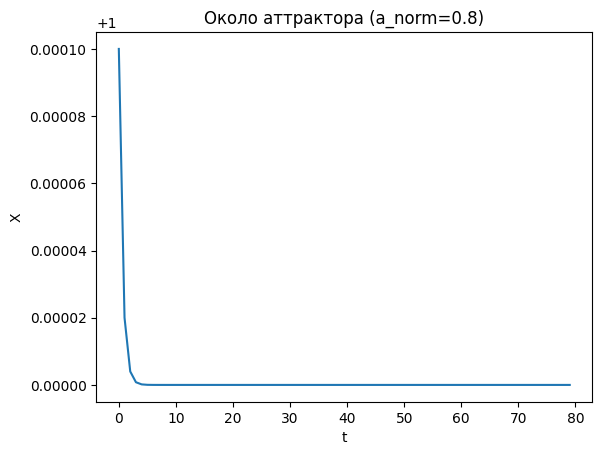

In [15]:

df_stable = simulate_verhulst(n_steps=200, x0=0.005, a_norm=0.8, K=1.0)
x_star = df_stable['X'].iloc[-1]
df_local = simulate_verhulst(n_steps=80, x0=float(x_star)+1e-4, a_norm=0.8, K=1.0)
plt.figure()
plt.plot(df_local['t'], df_local['X'])
plt.xlabel('t'); plt.ylabel('X'); plt.title('Около аттрактора (a_norm=0.8)')
plt.show()


### 📘 Что изображено
Мы изучаем поведение **в окрестности устойчивой точки** $x^* = 1$ для базовой модели:
$$
x_{t+1} = x_t + a_{\text{norm}}\,x_t(1 - x_t), \qquad a_{\text{norm}} = 0.8.
$$
Старт задан как $x_0 = x^* + 10^{-4}$, а на графике показано **отклонение** $y_t = x_t - x^*$  
(поэтому шкала около нуля и подпись “+1” над графиком).

---

### 🔎 Наблюдение
- $y_t$ **быстро и монотонно** стремится к нулю (затухает без смены знака).  
- Уже через несколько шагов отклонение практически исчезает.

---

### 🧠 Почему так (линеаризация)
В окрестности $x^*$ справедлива линейная аппроксимация:
$$
y_{t+1} \approx g'(x^*)\,y_t, \quad \text{где} \quad g'(x)=1+a_{\text{norm}}(1-2x),
$$
откуда $g'(1)=1-a_{\text{norm}}$.

При $a_{\text{norm}} = 0.8$ получаем $g'(1) = 0.2$, то есть:
$$
y_{t+1} \approx 0.2\,y_t \;\Rightarrow\; \text{геометрическое затухание без колебаний.}
$$

---

### 📊 Связь с регрессией по лагу 1
Если регрессировать отклонения $y_t$ на $y_{t-1}$ (AR(1)),
то оценка коэффициента при лаге 1 должна быть близка к
$$
\hat{\beta}_1 \approx 1 - a_{\text{norm}} = 0.2.
$$

- При $a_{\text{norm}} < 1$: $1 - a_{\text{norm}} > 0$ — **монотонное** затухание.  
- При $a_{\text{norm}} > 1$: $1 - a_{\text{norm}} < 0$ — **знако-переменное** (перерегулирование).  
- При $a_{\text{norm}} \to 2$: $1 - a_{\text{norm}} \to -1$ — **граница flip-бифуркации**.

---

### ✅ Вывод
Для $a_{\text{norm}} = 0.8$ базовая модель находится **глубоко в устойчивой зоне**:  
малые возмущения быстро затухают без колебаний,  
а локальная AR(1)-регрессия отклонений даёт коэффициент $\approx 0.2$,  
что согласуется с теорией $g'(1)=1-a_{\text{norm}}$.


## 6) Комбинированная модель и скан по $(\gamma, RQ)$

/var/folders/wf/668bg_rx2yz5wvf7tvqh_bm40000gq/T/ipykernel_94470/2661988951.py:142: RuntimeWarning: invalid value encountered in scalar divide
  beta = model.params.get(col, 0) * (X_std[col].std(ddof=0) / y_sigma)
/var/folders/wf/668bg_rx2yz5wvf7tvqh_bm40000gq/T/ipykernel_94470/2661988951.py:142: RuntimeWarning: divide by zero encountered in scalar divide
  beta = model.params.get(col, 0) * (X_std[col].std(ddof=0) / y_sigma)
/Users/v.l.gukasyan/Desktop/DIPLOM/experiments/.venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/var/folders/wf/668bg_rx2yz5wvf7tvqh_bm40000gq/T/ipykernel_94470/2661988951.py:142: RuntimeWarning: invalid value encountered in scalar divide
  beta = model.params.get(col, 0) * (X_std[col].std(ddof=0) / y_sigma)
/Users/v.l.gukasyan/Desktop/DIPLOM/experiments/.venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: Run

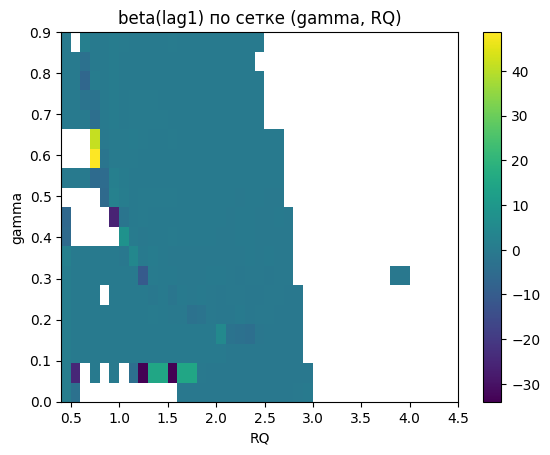

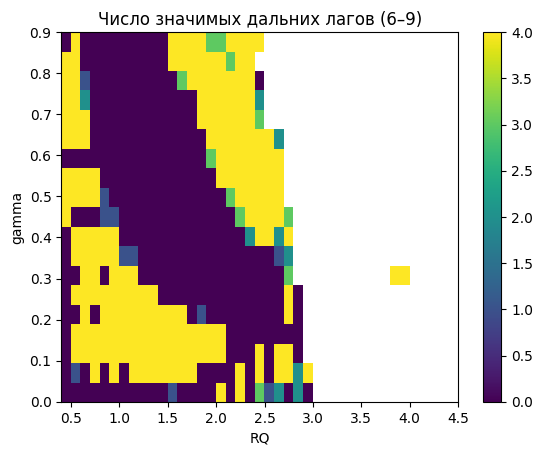

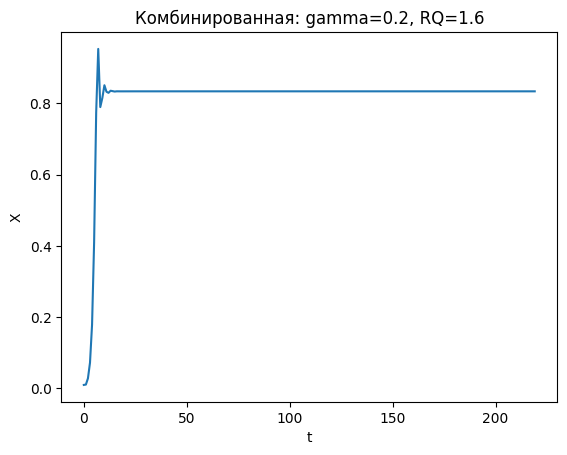

Adj. R^2: -1.476
Betas:
y_lag1    1.643270e+14
y_lag6    1.643270e+14
y_lag7    1.643270e+14
y_lag8    3.302770e+14
y_lag9    1.643270e+14
dtype: float64


In [16]:

gammas = np.linspace(0.0, 0.9, 19)
RQs = np.linspace(0.4, 4.5, 41)
scan = scan_gamma_RQ(n_steps=200, warmup=60, gammas=gammas, RQs=RQs, noise_std=0.0, random_state=0)

pivot_beta = scan.pivot(index='gamma', columns='RQ', values='beta_lag1')
plt.figure()
plt.imshow(pivot_beta.values, aspect='auto', origin='lower', extent=[RQs.min(), RQs.max(), gammas.min(), gammas.max()])
plt.xlabel('RQ'); plt.ylabel('gamma'); plt.title('beta(lag1) по сетке (gamma, RQ)'); plt.colorbar()
plt.show()

pivot_sig = scan.pivot(index='gamma', columns='RQ', values='sig_far_lags')
plt.figure()
plt.imshow(pivot_sig.values, aspect='auto', origin='lower', extent=[RQs.min(), RQs.max(), gammas.min(), gammas.max()])
plt.xlabel('RQ'); plt.ylabel('gamma'); plt.title('Число значимых дальних лагов (6–9)'); plt.colorbar()
plt.show()

# Пример траектории по заданной точке
gamma_sel, RQ_sel = 0.2, 1.6  # изменяй по необходимости
df_ex = simulate_combined(n_steps=220, x0=0.01, x1=0.011, gamma=gamma_sel, RQ=RQ_sel, random_state=10)
plt.figure()
plt.plot(df_ex['t'], df_ex['X'])
plt.xlabel('t'); plt.ylabel('X'); plt.title(f'Комбинированная: gamma={gamma_sel}, RQ={RQ_sel}')
plt.show()

series = df_ex['X'].iloc[60:]
res_ex = fit_lag_regression(series, lags=[1,6,7,8,9])
print("Adj. R^2:", round(res_ex['adj_r2'],3))
print("Betas:"); print(res_ex['betas'].round(3))


## 🧭 Комбинированная модель: чтение теплокарт и траектории

### Что нарисовано
- **Слева** — карта `beta(lag1)` по сетке $(\gamma, RQ)$ (после прогрева `warmup=60`).
- **По центру** — карта **числа значимых дальних лагов** (6–9) на той же сетке.
- **Справа** — траектория при $(\gamma, RQ) = (0.2,\,1.6)$.

Пустые (белые) клетки — точки, где регрессию адекватно оценить не удалось
(взрыв/вырождение ряда → `NaN/inf` или слишком мало «живых» наблюдений после `dropna()`).

---

### 1) Карта `beta(lag1)`
- Большая часть областей даёт **умеренные значения** β₁ (ровный «фон»).
- **Яркие пятна** (жёлтые/фиолетовые) — места, где $|\beta_1|$ скачет до больших чисел:
  это **околокритические** зоны (границы устойчивости), где линейная AR(1) становится плохо обусловленной.
- Диагональная «дорожка» локальных экстремумов от малых $RQ$ к большим при росте $\gamma$
  — эмпирический след **ломаной границы устойчивости** из описания Полунина
  (левая ветка «треугольника устойчивости» при малых $\gamma$, правая — «граница якобиана» при больших $\gamma$).

**Интерпретация:** когда система подходит к потере устойчивости, регрессия «видит» это как
аномально большие/нестабильные оценки β₁.

---

### 2) Карта числа значимых дальних лагов (6–9)
- **Тёмная зона (0)** — «простая» динамика: после прогрева ряд близок к фикс-пункту (или гладко затухает).
- **Жёлтая полоса (4)** — область, где **все четыре дальних лага** становятся значимыми:
  это индикатор **многопериодичности/квазипериодичности** (дискретный Хопф/Neimark–Sacker-ветка).
- Пятнистость на границах — нормальна: в окрестности бифуркаций оценивание чувствительно к стартовым условиям,
  длине ряда и численной чистке.

**Интерпретация:** чем дальше «вправо-вверх» от устойчивой зоны, тем чаще появляются
значимые дальние лаги — след сложной (не AR(1)) динамики.

---

### 3) Траектория при $(\gamma, RQ)=(0.2,\,1.6)$
График показывает **устойчивое поведение** с небольшим перерегулированием и быстрым выходом
на стационар. После `warmup=60` хвост ряда практически **плоский** (почти константа).

- В такой точке и **β₁** должен быть «нормальным», и **дальних лагов** обычно **нет**.
- Если на твоей карте в этой окрестности вдруг «жёлтая» клетка по числу дальних лагов, это чаще всего
численный артефакт: хвост почти константа ⇒ $TSS\to 0$ ⇒ p-values/стандартизации «шумят».

---

### Почему местами бело/пятнисто
1) **Вырождение**: после прогрева ряд стал почти константой ⇒ $TSS \approx 0$.
2) **Взрыв**: траектория уходит в $\pm\infty$ или `NaN` из-за выхода за устойчивость.
3) **Порог значимости**: $p<0.05$ вблизи границы работает нестабильно; небольшое смещение сетки даёт «пятна».

---

### Как стабилизировать и прочитать карты ещё чище
- Добавь **крошечный шум** к симуляции (`noise_std=1e-6 … 1e-4`) — он «разлипает» хвосты и убирает $TSS\approx 0$.
- Увеличь `warmup` (например, до 100–150), чтобы анализировать именно **режим**, а не переходник.
- Маскируй клетки, где `nobs` мал или `std(y_tail)` < $\varepsilon$ — выводи их как `NaN` (белые), не интерпретируй.
- Для иллюстрации **flip-ветки** сравни: $(\gamma, RQ) \approx (0.2, 1.9)$ (период-2)
  и **Neimark–Sacker**: $(0.6, 2.2)$ (многопериодичность) — в этих точках траектории и p-картина будут контрастно разными.

---

### Короткий итог
- **Левая тёмная область** (малые $RQ$): устойчивый фикс-пункт, дальние лаги незначимы.  
- **Диагональная зона**: околокритическое поведение — скачки $\beta_1$ и «пятнистость» значимостей.  
- **Жёлтая полоса** на карте дальних лагов: устойчивые колебания/квазипериодичность, линейная модель с одним-двумя лагами
  ряд **не описывает**, регрессия «просит» дальние лаги.

Точка $(\gamma, RQ)=(0.2,\,1.6)$ по траектории — **устойчивый режим** (слабое перерегулирование); для неё ожидаемо:
$\beta_1$ без аномалий, дальние лаги незначимы (если нет численной деградации из-за $TSS\!\approx\!0$).
